# Book Recommender

In [ ]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [ ]:
user.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
rating.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)

In [ ]:
df.head()

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0


In [ ]:
df.shape

(1149780, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


In [ ]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::200000, :])

Dataset shape: (1149780, 3)
-Dataset examples-
         userID        ISBN  bookRating
0             2  0195153448           0
200000    48494  0871233428           0
400000    98391  0670032549          10
600000   147513  0470832525           5
800000   196502  0590431862           0
1000000  242157  0732275865           0


## EDA

### Ratings Distribution

In [ ]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that over 62% of all ratings in the data are 0, and very few ratings are 1 or 2, or 3, low rating books mean they are generally really bad.

### Ratings Distribution By Book

In [ ]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,ISBN,bookRating
247408,0971880107,2502
47371,0316666343,1295
83359,0385504209,883
9637,0060928336,732
41007,0312195516,723
101670,044023722X,647
166705,0679781587,639
28153,0142001740,615
166434,067976402X,614
153620,0671027360,586


Most of the books received less than 5 ratings, and very few books have many ratings, although the most rated book has received 2,502 ratings.

### Ratings Distribution By User

In [ ]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,userID,bookRating
4213,11676,13602
74815,198711,7550
58113,153662,6109
37356,98391,5891
13576,35859,5850
80185,212898,4785
105111,278418,4533
28884,76352,3367
42037,110973,3100
88584,235105,3067


Most of the users gave less than 5 ratings, and very few users gave many ratings, although the most productive user have given 13,602 ratings.

I'm sure you have noticed that the above two charts share the same distribution. The number of ratings per movie and the number of ratings per user decay exponentially.

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users.

In [ ]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


## Surprise

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [ ]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

With the Surprise library, we will benchmark the following algorithms

### Basic algorithms

#### NormalPredictor

* NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

* BasiclineOnly algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms

#### KNNBasic

* KNNBasic is a basic collaborative filtering algorithm.

#### KNNWithMeans

* KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

#### KNNWithZScore

* KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

#### KNNBaseline

* KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms

#### SVD

* SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

#### SVDpp

* The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

#### NMF

* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

### Slope One

* Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

### Co-clustering

* Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)


We use rmse as our accuracy metric for the predictions.

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

,fit_time,test_rmse,test_time
Algorithm,,,
BaselineOnly,0.233249,3.379186,0.319563
CoClustering,2.294557,3.466180,0.273204
SlopeOne,0.769663,3.474766,3.031999
KNNWithMeans,0.755913,3.489696,4.461669
KNNBaseline,0.880004,3.490825,5.455574
KNNWithZScore,0.862389,3.508873,4.919546
SVD,5.547440,3.541042,0.306871
KNNBasic,0.667804,3.725668,4.032472
SVDpp,136.691374,3.790323,4.714200


BaselineOnly algorithm gave us the best rmse, therefore, we will proceed further with BaselineOnly and use Alternating Least Squares (ALS).

In [ ]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.13807177543640137, 0.12630414962768555, 0.1693267822265625),
 'test_rmse': array([ 3.37381566,  3.36756676,  3.37800743]),
 'test_time': (0.2851989269256592, 0.322648286819458, 0.3984529972076416)}

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3581


3.3581150404412017

In [ ]:
# dump.dump('./dump_file', predictions, algo)
# predictions, algo = dump.load('./dump_file')

In [ ]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [ ]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,229741,0451167805,7.0,4.080891,{'was_impossible': False},79,36,2.919109
1,234765,0399501487,10.0,4.113245,{'was_impossible': False},26,128,5.886755
2,16106,0805063897,0.0,2.618840,{'was_impossible': False},67,112,2.618840
3,138529,014028009X,7.0,3.166524,{'was_impossible': False},8,128,3.833476
4,213531,0671867156,8.0,3.725626,{'was_impossible': False},11,79,4.274374


In [ ]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
13857,269566,0061098795,0.0,0.0,{'was_impossible': False},276,30,0.0
14688,102967,051512317X,0.0,0.0,{'was_impossible': False},384,59,0.0
14689,238781,0451203895,0.0,0.0,{'was_impossible': False},178,76,0.0
26302,63938,0380817446,0.0,0.0,{'was_impossible': False},71,26,0.0
14712,244736,0061098795,0.0,0.0,{'was_impossible': False},77,30,0.0
14720,278418,0743460529,0.0,0.0,{'was_impossible': False},174,51,0.0
2771,170518,080411868X,0.0,0.0,{'was_impossible': False},155,105,0.0
14737,238545,0440241073,0.0,0.0,{'was_impossible': False},41,146,0.0
26275,238120,0553297260,0.0,0.0,{'was_impossible': False},314,34,0.0
26273,36836,0394742117,0.0,0.0,{'was_impossible': False},158,25,0.0


The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 26 to 146, they are not really small, meaning that significant number of users have rated the target book.

In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
4430,263460,0061097101,10.0,0.317065,{'was_impossible': False},61,88,9.682935
12250,129358,0515128546,10.0,0.314570,{'was_impossible': False},97,80,9.685430
33088,35857,0380710722,10.0,0.285230,{'was_impossible': False},191,59,9.714770
1934,78834,0399145990,10.0,0.279658,{'was_impossible': False},154,17,9.720342
2419,226006,0425100650,10.0,0.260445,{'was_impossible': False},14,42,9.739555
29657,14521,0553275976,10.0,0.169291,{'was_impossible': False},156,84,9.830709
2794,14521,0553269631,10.0,0.070703,{'was_impossible': False},156,27,9.929297
25532,115490,081297106X,10.0,0.028978,{'was_impossible': False},159,41,9.971022
30944,182442,0679433740,10.0,0.000000,{'was_impossible': False},36,33,10.000000
5395,26544,055358264X,10.0,0.000000,{'was_impossible': False},191,47,10.000000


The worst predictions look pretty surprise. Let's look in more details of the last one ISBN "055358264X", the book was rated by 47 users, user "26544" rated 10, our BaselineOnly algorithm predicts 0.

In [ ]:
df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].describe()

count    60.000000
mean      1.283333
std       2.969287
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.000000
Name: bookRating, dtype: float64

<IPython.core.display.Javascript object>


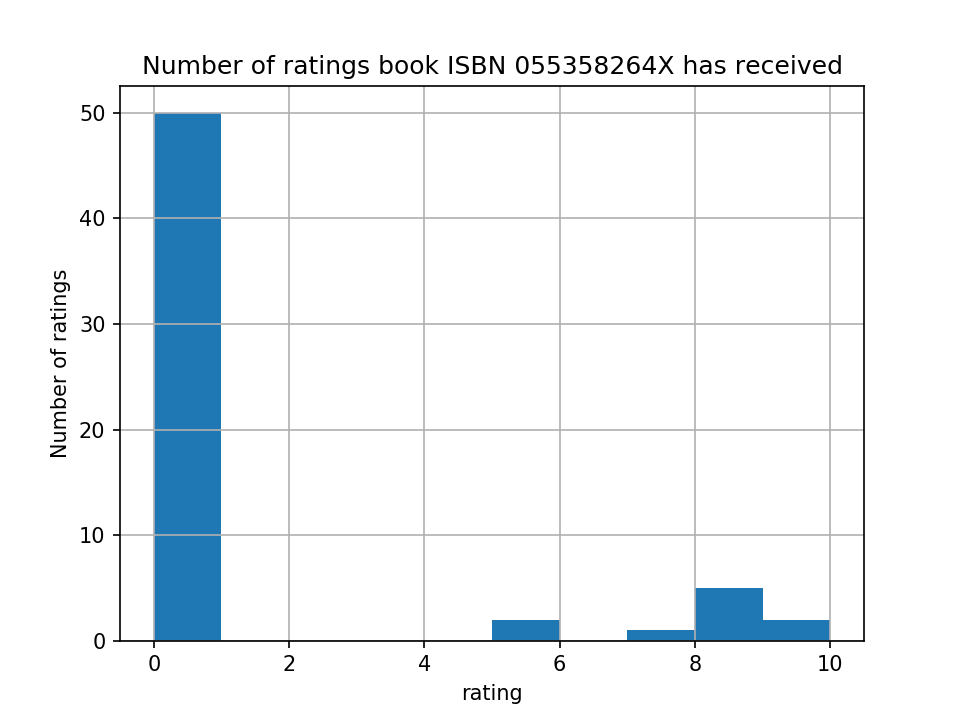

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show();

It turns out, most of the ratings this book received was "0", in another word, most of the users in the data rated this book "0", only very few users rated "10". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.